In [ ]:
!pip install -q torch torchvision transformers matplotlib scipy
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c imagenet-object-localization-challenge
!rm -r path_to_image_folder

In [ ]:
import os
import requests
from concurrent.futures import ThreadPoolExecutor


def download_image(folder, index):
    url = "https://picsum.photos/224"
    img_data = requests.get(url).content
    with open(f'{folder}/image_{index}.jpg', 'wb') as handler:
        handler.write(img_data)

def download_images_parallel(folder, num_images=100, num_workers=10):
    os.makedirs(folder, exist_ok=True)

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        executor.map(lambda i: download_image(folder, i), range(1, num_images + 1))

if not os.path.exists('path_to_image_folder'):
    download_images_parallel('path_to_image_folder')

100


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
from transformers import ViTModel, ViTFeatureExtractor
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import numpy as np
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1]:
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

def compute_cosine_similarity_across_layers(hidden_states):
    layer_similarities = []
    for layer in hidden_states:
        patches = layer[:, 1:, :]  # Ignore class token, get patches
        num_patches = patches.shape[1]
        similarities = []
        patches = patches.cpu().detach()
        for i in range(num_patches):
            for j in range(i + 1, num_patches):
                similarity = F.cosine_similarity(patches[:, i], patches[:, j], dim=-1)
                similarities.append(similarity.mean())
        layer_similarities.append(similarities)
    return layer_similarities


# Custom dataset class for CIFAR-100 that integrates with AutoImageProcessor for processing
class CIFAR100Dataset(Dataset):
    def __init__(self, root, train=True, size=None, processor=None):
        self.dataset = torchvision.datasets.CIFAR100(root=root, train=train, download=True)           # Load CIFAR-100 dataset from torchvision
        if size is not None:
            self.dataset = Subset(self.dataset, torch.arange(size))                                  # Optionally, load only count number of samples
        
        self.processor = processor                                                                    # Store the processor (used to preprocess images before passing to the model)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx] 
        
        # Preprocess the image and convert it to tensor format suitable for the model
        inputs = self.processor(images=image, return_tensors="pt")
        # Return the processed pixel values and label
        return inputs['pixel_values'].squeeze(0), label        


# Function to evaluate the model on the test data
def test(model, dataloader):
    model.eval()

    with torch.no_grad():             # Disable gradient computation for efficiency
        for (inputs, labels) in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
pretrained_cifar_model_name = "Ahmed9275/Vit-Cifar100"
print(device)

data_path = 'data'
batch_size = 64
test_size = 10

cifar_processor = AutoImageProcessor.from_pretrained(pretrained_cifar_model_name)   # Initialize the image processor for CIFAR-100 data pre-processing
pretrained_cifar_model = AutoModelForImageClassification.from_pretrained(pretrained_cifar_model_name)

test_dataset = CIFAR100Dataset(root=data_path, train=False, size=test_size, processor=cifar_processor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
first_batch = next(iter(test_loader))

all_hidden_states = pretrained_cifar_model(first_batch[0], output_hidden_states=True).hidden_states

/user/ai21btech11011/miniforge3/envs/himanshu_mp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:2
Files already downloaded and verified


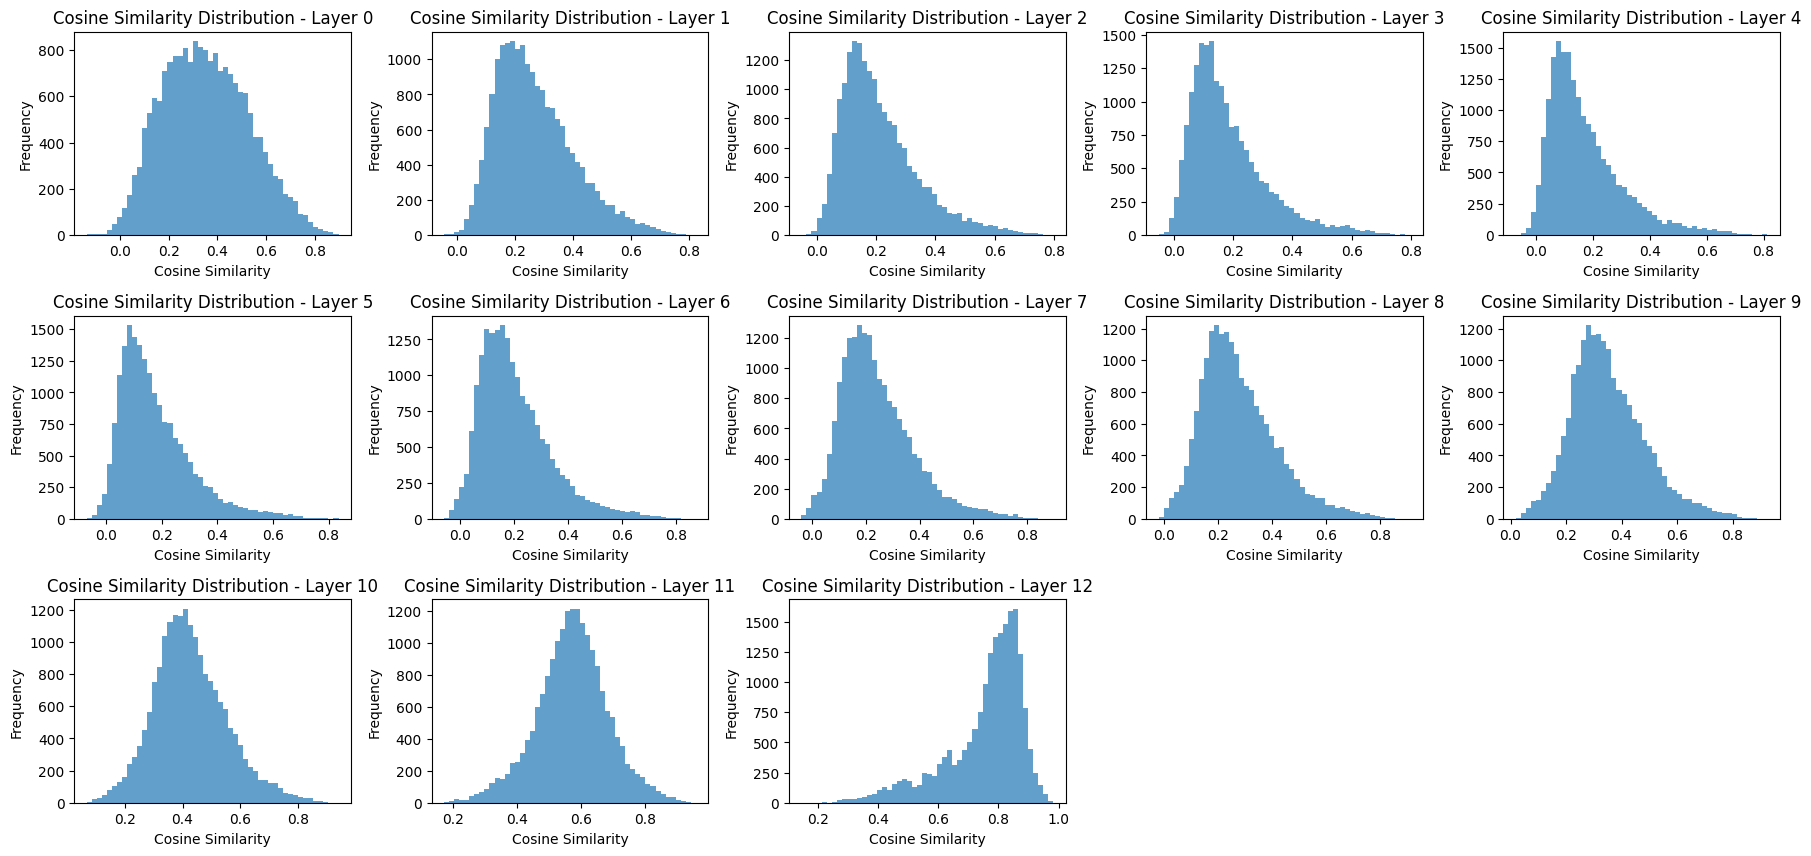

In [2]:
similarity = compute_cosine_similarity_across_layers(all_hidden_states)

def plot_cosine_similarity(layer_similarities):
    num_layers = len(layer_similarities)
    plt.figure(figsize=(18, num_layers / 1.5))

    for i, similarities in enumerate(layer_similarities):
        plt.subplot(int(num_layers // 5 + 1), 5, i + 1)
        plt.hist(similarities, bins=50, alpha=0.7)
        plt.title(f'Cosine Similarity Distribution - Layer {i}')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_cosine_similarity(similarity)


## Above are the distributions of cosine similarity at each layer

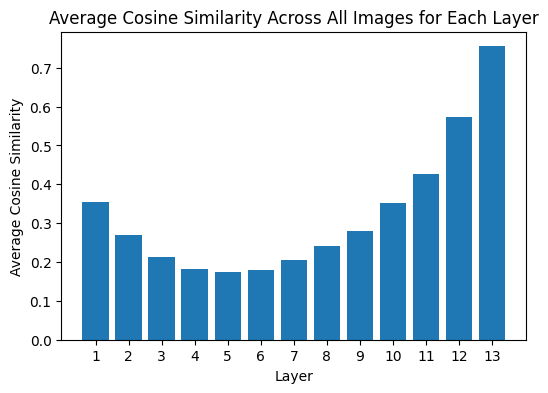

In [6]:
def plot_average_cosine_similarity(avg_layer_similarities):
    num_layers = len(avg_layer_similarities)
    plt.figure(figsize=(6, 4))

    plt.bar(range(1, num_layers + 1), avg_layer_similarities)
    plt.title('Average Cosine Similarity Across All Images for Each Layer')
    plt.xlabel('Layer')
    plt.ylabel('Average Cosine Similarity')

    plt.xticks(range(1, num_layers + 1))
    plt.show()


import numpy as np
avg_layer_similarities = np.array(similarity).mean(axis=-1)
plot_average_cosine_similarity(avg_layer_similarities)

## Plot of average cosine similarity of all patches across each layer

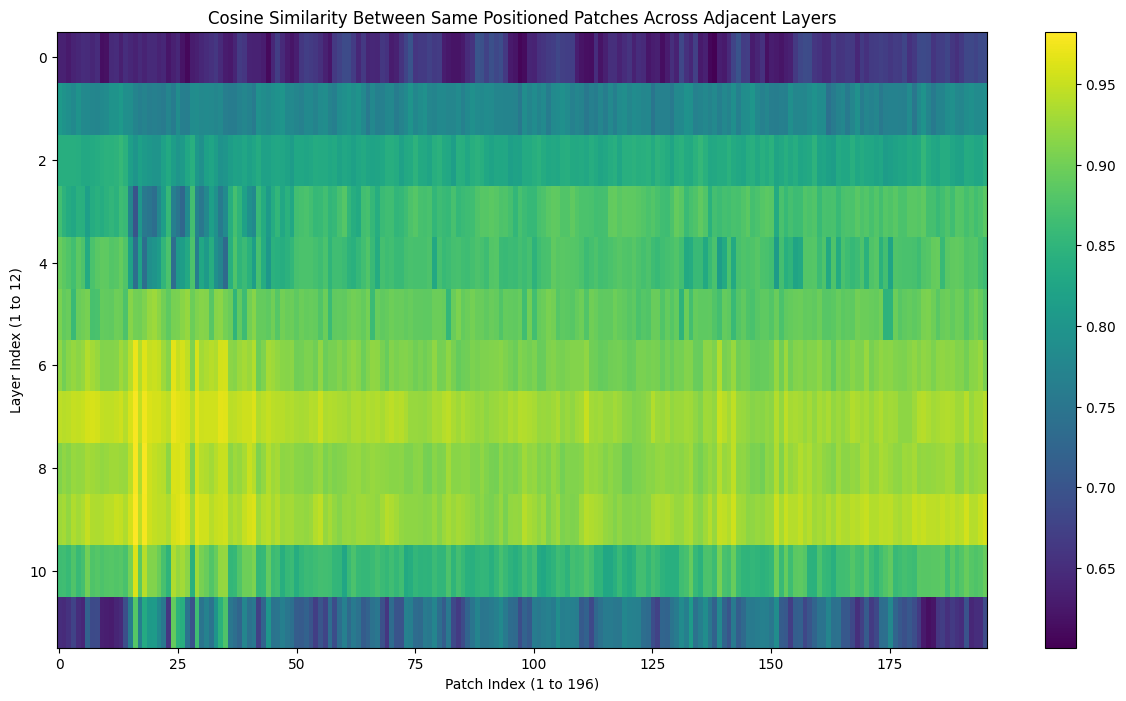

In [11]:
# import seaborn as sns

def compute_cosine_similarity_across_adjacent_layers(hidden_states):
    num_layers = len(hidden_states)
    num_patches = hidden_states[0].shape[1] - 1  # Ignore class token, so patches = 196

    layer_patch_similarities = torch.empty((num_layers - 1, num_patches))

    for layer_idx in range(num_layers - 1):
        patches_layer_1 = hidden_states[layer_idx][:, 1:, :]
        patches_layer_2 = hidden_states[layer_idx + 1][:, 1:, :]

        for patch_idx in range(num_patches):
            similarity = F.cosine_similarity(
                patches_layer_1[:, patch_idx].cpu().detach(),
                patches_layer_2[:, patch_idx].cpu().detach(), dim=-1
            )
            layer_patch_similarities[layer_idx, patch_idx] = similarity.mean()

    return layer_patch_similarities

def plot_heatmap(layer_patch_similarities):
    plt.figure(figsize=(15, 8))

    # sns.heatmap(layer_patch_similarities, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.imshow(layer_patch_similarities, cmap='viridis', interpolation='nearest', aspect='auto')
    plt.colorbar()  # Adds a colorbar to show the scale

    plt.title('Cosine Similarity Between Same Positioned Patches Across Adjacent Layers')
    plt.xlabel('Patch Index (1 to 196)')
    plt.ylabel('Layer Index (1 to 12)')
    plt.show()


avg_layer_patch_similarities = compute_cosine_similarity_across_adjacent_layers(all_hidden_states)

plot_heatmap(avg_layer_patch_similarities)



## Plot for average cosine similarity of patches in same spacial location,  taken consecutively accross all the layers<br>
We can see that there is high similarity b/w patches in same spacial location

In [ ]:
from PIL import Image
import os
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTFeatureExtractor
import torch
import requests


transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

images_list = []
images_list2 = []
for image_name in os.listdir('images'):
    print(image_name)
    img = Image.open(os.path.join('images', image_name)).convert('RGB')
    images_list2.append(img)
    img_tensor = transform(img)
    images_list.append(img_tensor)

batch_tensor = torch.stack(images_list)

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# inputs = feature_extractor(images=images_list2, return_tensors="pt", padding=True)


ILSVRC2012_val_00000006.JPEG
ILSVRC2012_val_00000002.JPEG
ILSVRC2012_val_00000001.JPEG
ILSVRC2012_val_00000008.JPEG
ILSVRC2012_val_00000005.JPEG
ILSVRC2012_val_00000004.JPEG
ILSVRC2012_val_00000003.JPEG
ILSVRC2012_val_00000007.JPEG
ILSVRC2012_val_00000009.JPEG
ILSVRC2012_val_00000010.JPEG
tensor([[-0.1025,  0.3237,  0.2765,  ...,  0.4073,  0.1515, -0.0669],
        [ 0.0079,  0.2038,  0.2426,  ...,  0.1424,  0.2494,  0.0408],
        [-0.1027,  0.2162, -0.1941,  ..., -0.0306,  0.1618, -0.1055],
        ...,
        [-0.2153, -0.2777, -0.0893,  ...,  0.2312,  0.0735, -0.0955],
        [-0.3515,  0.1589,  0.0055,  ...,  0.4634, -0.0737, -0.0179],
        [-0.0718,  0.5649,  0.2407,  ...,  0.4938, -0.4325, -0.5556]])
Predicted class index for image 1: 513
cornet
Predicted class index for image 2: 961
dough
Predicted class index for image 3: 824
scarf
Predicted class index for image 4: 718
pier
Predicted class index for image 5: 879
umbrella
Predicted class index for image 6: 742
printer
P

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load images for training
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('RGB')
        if img is not None:
            img_tensor = transform(img).to(device)
            images.append(img_tensor)
    return torch.stack(images)

# Load training images
images_folder = 'images'
batch_tensor = load_images_from_folder(images_folder).to(device)

Epoch 1/10, Loss: 0.3324
Epoch 2/10, Loss: 0.6830
Epoch 3/10, Loss: 0.0977
Epoch 4/10, Loss: 0.0025
Epoch 5/10, Loss: 0.0002
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Training complete.


In [ ]:
import os
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import requests

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load images for testing
def load_images_from_folder(folder):
    images = []
    image_names = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('RGB')
        if img is not None:
            img_tensor = transform(img).to(device)
            images.append(img_tensor)
            image_names.append(filename)
    return torch.stack(images), image_names

# Load test images
test_images_folder = 'images'
batch_tensor, image_names = load_images_from_folder(test_images_folder)

# Use the model that was trained in the training loop
# Assuming modified_vit_model is the trained model from training code

# Print results
for idx, class_index in enumerate(predicted_class_indices):
    print(f"Predicted class index for image '{image_names[idx]}': {class_index}")
    print(f"Predicted class name: {class_names[class_index]}")


In [ ]:
from transformers.models.vit.modeling_vit import ViTModel, ViTAttention, ViTLayer, ViTEncoder, ViTConfig
from transformers import ViTForImageClassification
import torch.nn.functional as F


config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
pretrained_vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

pretrained_classification_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')